Gu Huaqing Github Username: JuliaGHQ USC ID: 2433803934

**For EfficientNetB0 part**

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import os
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization,Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras import applications, optimizers

In [ ]:
from tensorflow.keras.optimizers import Adam

from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from pathlib import Path

**(a)&(b) Download the data and split them into train test and validation files.**

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Same as the VGG16 model training, for EfficientNetB0 model, we also split the files first into ratio(0.7,0.15,0.15).
import splitfolders

input_folder = '/content/drive/MyDrive/Colab Notebooks/552/images'
splitfolders.ratio(input_folder, output="output", seed=1, ratio=(0.7, 0.15,0.15), group_prefix=None, move=False) 


Copying files: 1176 files [00:05, 213.32 files/s]


In [ ]:
#Make sure the Batch size for processing and set the ImageDataGenerator to do the image augementation for train, validation and test sets. 
#The number of samples that will be propagated through the network is 64 to make sure the model is more  accurate. 
BATCH_SIZE = 64 

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     shear_range=0.2,
                                     zoom_range=[0.1, 0.7],
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing
val_generator = ImageDataGenerator(preprocessing_function=preprocess_input)  # VGG16 preprocessingw
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessingw

In [ ]:
#Import the image or the data from the file path. 
download_dir = Path('/content/drive/MyDrive/Colab Notebooks/552/images')

train_data_dir = "/content/output/train"
test_data_dir = "/content/output/test"
valid_data_dir = "/content/output/val"

*Do One Hot Encoding for the Dataset*

In [ ]:
#Separate train, valid and test sets with target size and one hot encoding. 
class_subset = sorted(os.listdir(download_dir))

train_gen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

valid_gen = val_generator.flow_from_directory(valid_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',       #OneHotEncoder
                                               classes=class_subset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=False,
                                               seed=42)

test_gen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 820 images belonging to 20 classes.
Found 171 images belonging to 20 classes.
Found 185 images belonging to 20 classes.


**(c) Transfer learning EfficientNetB0 model and use Relu and train the EfficientNetB0 model for at least 50 epochs**

In [ ]:
#Define the EfficientNetB0 model itself. 
effB0_model = applications.EfficientNetB0(weights='imagenet', include_top=False,
                                          input_shape=(224, 224, 3))


In [ ]:
#Define the shape, the optimizer, the learning rate, class numbers and epoches for the EfficientNetB0 model runnning.
input_shape = (224, 224, 3)
optim_2 = Adam(learning_rate=0.0001)
n_classes = 20

n_steps = train_gen.samples // BATCH_SIZE
n_val_steps = valid_gen.samples // BATCH_SIZE
n_epochs = 50

In [ ]:
#Define the layers in the EfficientNetB0.
layer_dict = dict([(layer.name, layer) for layer in effB0_model.layers])

top_model = layer_dict['top_activation'].output

#Add layers to the model
#Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization
#and a dropout rate of 20% as well as ADAM optimizer.
top_model = BatchNormalization()(top_model)
top_model = Flatten()(top_model)
top_model = Dense(4096, activation='relu')(top_model)
top_model = Dense(1072, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
output_layer = Dense(n_classes, activation='softmax')(top_model)

In [ ]:
#Create a new EfficientNetB0 model
custom_effB0_model = Model(inputs=effB0_model.input, outputs=output_layer)

In [ ]:
#Compile it
#Use multinomial cross entropy loss.
custom_effB0_model.compile(optimizer=optim_2, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_2 = PlotLossesCallback()

#Create checkpoint for EfficientNetB0. 
tl_checkpoint_2 = ModelCheckpoint(filepath='tl_model_v2.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

#EarlyStopping using validation set.
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

**Plot the Training and Validation errors vs. epochs graph**

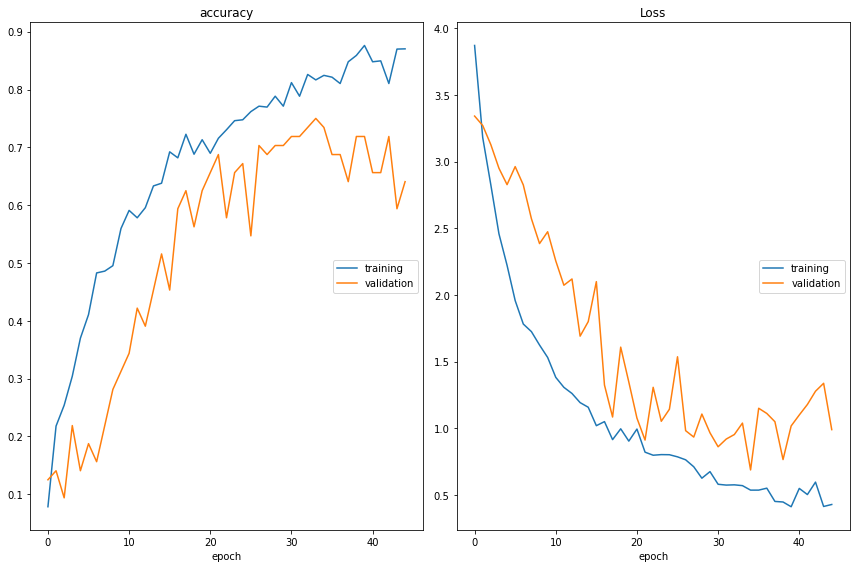

accuracy
	training         	 (min:    0.078, max:    0.876, cur:    0.870)
	validation       	 (min:    0.094, max:    0.750, cur:    0.641)
Loss
	training         	 (min:    0.410, max:    3.872, cur:    0.427)
	validation       	 (min:    0.687, max:    3.342, cur:    0.989)
10/10 [==============================] - 15s 1s/step - loss: 0.4273 - accuracy: 0.8703 - val_loss: 0.9891 - val_accuracy: 0.6406
CPU times: user 16min 36s, sys: 1min 32s, total: 18min 8s
Wall time: 18min 10s


In [ ]:
#Plot the graph with training and validation together. 
%%time 

effB0_history = custom_effB0_model.fit(train_gen,
                          batch_size=BATCH_SIZE,
                          epochs=n_epochs,
                          validation_data=valid_gen,
                          steps_per_epoch=n_steps,
                          validation_steps=n_val_steps,
                          callbacks=[tl_checkpoint_2, early_stop, plot_loss_2],
                          verbose=1)

From the graph above, the accuracy and loss analysis give us a good insights of the training using EfficientNetB0 model. The results of the traininng set accuracy here is better than the validation set. The highest accuracy for the training set is 0.876, which is 87.6%, and the highest accuracy for the validation set is 0.750, which is 75%. This graph also shows the training and validation set accuracy constantly increases during training. It is a good sign. Moreover, the loss of the training and the validation set is constantly decrease during the training of EfficientNetB0 model. 

**Get the test results，average model accuracy and report the Precision, Recall, and F1 scores (Classification Report for multi-class.)**

In [ ]:
#Initialize the best trained weights
#Set the true classes and pred classes
custom_effB0_model.load_weights('tl_model_v2.weights.best.hdf5') 
true_classes = test_gen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

effB0_preds = custom_effB0_model.predict(test_gen)
effB0_pred_classes = np.argmax(effB0_preds, axis=1)

185/185 [==============================] - 3s 15ms/step


In [ ]:
effB0_preds

array([[9.9905902e-01, 1.0812301e-05, 7.8678157e-09, ..., 1.2208230e-10,
        5.5687060e-06, 2.0899373e-07],
       [4.9462765e-01, 1.0673289e-02, 8.6262524e-05, ..., 1.3027967e-05,
        5.1953453e-03, 4.3839950e-04],
       [1.2370394e-01, 4.6896061e-05, 4.3826722e-07, ..., 1.4336426e-05,
        6.5620450e-05, 7.7005490e-05],
       ...,
       [1.3564029e-01, 3.0274533e-03, 2.3193406e-02, ..., 4.1588832e-05,
        1.9800293e-03, 1.4155252e-01],
       [1.2482627e-07, 4.9701758e-09, 3.2829448e-08, ..., 2.1858273e-09,
        8.3445251e-05, 9.9985445e-01],
       [8.6506298e-03, 5.6355469e-02, 2.5207067e-02, ..., 1.1707186e-03,
        1.8013090e-01, 1.4383665e-01]], dtype=float32)

In [ ]:
from sklearn.metrics import accuracy_score
#Get the  average accuracy for the EfficientNetB0 model.
effB0_acc = accuracy_score(true_classes, effB0_pred_classes)

print("EfficientNetB0 Model Accuracy : {:.2f}%".format(effB0_acc * 100))

EfficientNetB0 Model Accuracy : 59.46%


## The Classification Report for EfficientNetB0 model:

In [ ]:
from PIL import Image
from sklearn.metrics import classification_report

y_true = true_classes
y_pred = effB0_pred_classes

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.62      0.56      0.59         9
           2       0.82      0.90      0.86        10
           3       0.73      0.80      0.76        10
           4       0.38      0.33      0.35         9
           5       0.35      0.67      0.46         9
           6       0.57      0.44      0.50         9
           7       0.64      0.78      0.70         9
           8       0.56      0.56      0.56         9
           9       0.67      0.67      0.67         9
          10       0.75      0.33      0.46         9
          11       0.82      1.00      0.90         9
          12       0.45      0.56      0.50         9
          13       0.64      0.78      0.70         9
          14       1.00      0.22      0.36         9
          15       0.50      0.40      0.44        10
          16       0.69      0.90      0.78        10
          17       0.40    

The above is the EfficientNetB0 model training classification report. 

**Reference**

https://github.com/jfilter/split-folders/blob/main/README.md

https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/

https://www.learndatasci.com/tutorials/convolutional-neural-networks-image-classification/

https://www.tensorflow.org/tutorials/images/data_augmentation#two_options_to_use_the_keras_preprocessing_layers

https://keras.io/api/layers/normalization_layers/batch_normalization/

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

https://scikit-learn.org/stable/modules/model_evaluation.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

https://towardsdatascience.com/transfer-learning-for-image-classification-using-tensorflow-71c359b56673

https://medium.com/analytics-vidhya/image-classification-with-vgg-convolutional-neural-network-using-keras-for-beginners-61767950c5dd

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

https://pypi.org/project/livelossplot/

https://github.com/keras-team/keras/blob/master/keras/applications/vgg16.py

https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

